<a href="https://colab.research.google.com/github/YuMan-Tam/deep-hedging-demo/blob/master/Deep_Hedging_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title <font color='Blue'>**Overheads**</font>
!apt-get update --fix-missing
!apt-get -qq install -y libquantlib0-dev
!pip -q install QuantLib pathos tqdm==4.41.1

%tensorflow_version 2.x

from tqdm import trange
from tqdm.keras import TqdmCallback
import pathos.multiprocessing as mp
from IPython.display import Math, HTML, clear_output

import numpy as np
import QuantLib as ql
import tensorflow as tf
from itertools import repeat
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
                                            ReduceLROnPlateau
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Disable warnings for presentation purpose
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import matplotlib.pyplot as plt

# Import custom modules from github
!rm -rf deep-hedging-demo
!git clone https://github.com/YuMan-Tam/deep-hedging-demo

import sys, os
sys.path.insert(0, os.getcwd() + "/deep-hedging-demo/lib")

from Stochastic_Processes import BlackScholesProcess
from Utilities import train_test_split, reshape_1D
from Deep_Hedging import Deep_Hedging
from Validation import Validation

clear_output()
print("\nFinish installing and importing all necessary libraries!")


Finish installing and importing all necessary libraries!


**Import all neccessary python, quantitative finance, and machine learning software libraries.**

In [0]:
#@title <font color='Blue'>**User Inputs**</font>

# Geometric Brownian Motion.
N = 30 # Number of time steps (in days)

S0 = 100.0 # Stock price at time = 0
sigma = 0.2 # Implied volatility
risk_free = 0.0 # Risk-free rate
dividend = 0.0 # Continuous dividend yield

Ktrain = 1*(10**5) # Size of training sample.
Ktest_ratio = 0.2 # Fraction of training sample as testing sample.

# European call option (short).
strike = S0
payoff_func = lambda x: -np.maximum(x - strike, 0.0)
calculation_date = ql.Date.todaysDate()
maturity_date = ql.Date.todaysDate() + N

# Proportional transaction cost.
epsilon = 0.005

# Neural network (NN) structure 
m = 15 # Number of neurons in each hidden layer.
d = 2 # Number of hidden layers (Note including input nor output layer)
strategy_type = "recurrent" # ("simple"/"recurrent")                                               
                
# Loss function
# loss_type = "CVaR" (Expected Shortfall) -> loss_param = alpha 
# loss_type = "Entropy" -> loss_param = lambda
loss_type = "CVaR"
loss_param = 0.5

# Other NN parameters
lr = 5e-3 # Learning rate
batch_size=256 # Batch size
epochs=100 # Number of epochs

**Provide input parameters for Monte Carlo simulation, call option, transaction cost, loss function, and deep hedging algorithm.**

In [3]:
#@title <font color='Blue'>**Monte Carlo Simulation - Generate Random Paths of Stock Prices**</font>
stochastic_process = BlackScholesProcess(s0 = S0, sigma = sigma, \
                      risk_free = risk_free, dividend = dividend)
maturity = N/365
S = stochastic_process.gen_path(maturity, N, \
                      int(Ktrain/(1-Ktest_ratio)))

print("\n\nSimulating geometric brownian motion with:\n")
print("s0 = " + str(S0))
print("sigma = " + str(sigma))
print("risk_free = " + str(risk_free) + "\n")
print("Number of time steps = " + str(N))
print("Length of each time step = " + "1/365\n")
print("Simulation Done!")

100%|██████████| 125000/125000 [00:22<00:00, 5509.08it/s]



Simulating geometric brownian motion with:

s0 = 100.0
sigma = 0.2
risk_free = 0.0

Number of time steps = 30
Length of each time step = 1/365

Simulation Done!


In [4]:
#@title <font color='Blue'>**Prepare data to be fed into the deep hedging algorithm.**</font>

payoff_T = payoff_func(S[:,-1]) # Payoff of the call option

trade_set =  np.stack((S),axis=1) # Trading set
I =  np.stack((S),axis=1) # Information set

# Structure of xtrain:
#   1) Certainty equivalent: w (dim = 1)
#   2) Trade set: [S]
#   2) Information set: [S] 
#   3) payoff (dim = 1)
xtrain = [np.zeros(len(S))]
for i in range(N+1):
    xtrain += [trade_set[i,:]]
    if i != N:
        xtrain += [I[i,:]]
xtrain += [payoff_T]

# Split the entire sample into a training sample and a testing sample.
[xtrain, xtest] = train_test_split(xtrain, test_size=Ktest_ratio)
[S_train, S_test] = train_test_split([S], test_size=Ktest_ratio)
[option_payoff_train, option_payoff_test] = \
    train_test_split([payoff_T], test_size=Ktest_ratio)

print("Finish preparing data!")

Finish preparing data!


In [5]:
#@title <font color='Blue'>**Run the Deep Hedging Algorithm!**</font>

optimizer = Adam(learning_rate=lr)

# Setup and compile the model
model = Deep_Hedging(N=N, d=d+2, m=m, risk_free=risk_free, \
                      maturity=maturity).model( \
                      strategy_type=strategy_type, epsilon = epsilon, \
                      loss_type=loss_type, loss_param = loss_param)
model.compile(optimizer=optimizer)

# Stopping criteria
saved_model_file = "saved_model.h5"

early_stopping = EarlyStopping(monitor="loss", \
          patience=10, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", \
          factor=0.9, patience=2, min_delta=1e-3, verbose=0)
model_checkpoint = ModelCheckpoint(saved_model_file, \
          monitor="loss", save_best_only=True, \
          save_weights_only=False, verbose=0)

callbacks = [early_stopping, reduce_lr, model_checkpoint, TqdmCallback()]

# Fit the model.
model_fit = model.fit(x=xtrain, batch_size=batch_size, epochs=epochs, \
            validation_data=(xtest, np.empty(0)), callbacks=callbacks, \
            verbose=0)

print("Finished running deep hedging algorithm!")


Finished running deep hedging algorithm!


In [6]:
#@title <font color='Blue'>**Results: Option Prices**</font>
report = Validation(model = model, data = xtest, N = N, process = stochastic_process)

# Specify the instrument as an European call option
instrument = report.get_instrument(name = "European_Call", strike = strike, \
                                    maturity_date = maturity_date)

BS_price = report.get_model_PV(instrument)
risk_neutral_price = report.get_risk_neutral_PV()
nn_price = model.evaluate(xtest, batch_size=batch_size, verbose=0)

print("The Black-Scholes model price is " + str(BS_price) + ".")
print("The Risk Neutral price is " + str(risk_neutral_price) + ".")
print("The Deep Hedging price is " + str(nn_price) + ".")

The Black-Scholes model price is 2.2871506280449694.
The Risk Neutral price is 2.2870801312608893.
The Deep Hedging price is 3.5674778003692627.


100%|██████████| 31/31 [00:49<00:00,  1.57s/it]


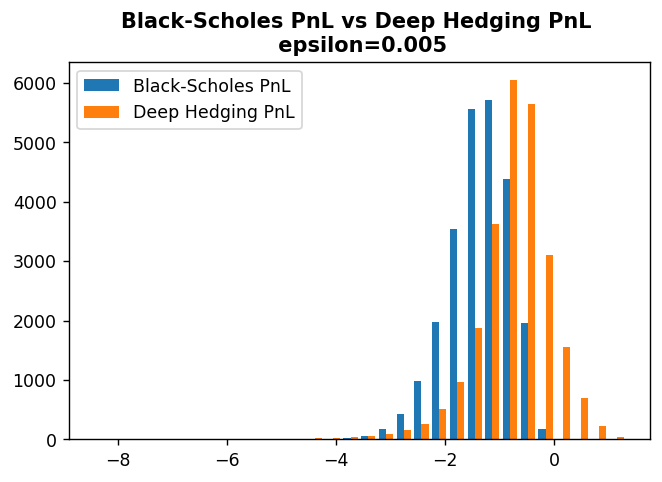

In [7]:
#@title <font color='Blue'>**Results: Black-Scholes PnL vs Deep Hedging PnL**</font>

# Compute Black-Scholes delta for each sample path at each time t.
length_test_sample = len(S_test[0][:,0])
model_delta = np.zeros((length_test_sample, N+1))
func_delta = lambda i, j: report.get_model_delta(instrument, \
                s0=S_test[0][i,j], calculation_date=calculation_date + j)

pool = mp.ProcessPool(nodes = mp.cpu_count())
for j in trange(N+1):
    model_delta[:,j]  = list(pool.map(func_delta, range(length_test_sample), \
                            repeat(j,length_test_sample)))

# Compute Black-Scholes PnL (for a short position, i.e. the Bank sells
# a call option. The model delta from Quantlib is a long delta.
PnL_BS = np.multiply(S_test[0][:,0], -model_delta[:,0]) - \
          np.abs(model_delta[:,0])*S_test[0][:,0]*epsilon
for t in range(1, N):
  PnL_BS += (np.multiply(S_test[0][:,t], -model_delta[:,t] + model_delta[:,t-1]) - \
               np.abs(model_delta[:,t] - model_delta[:,t-1])*S_test[0][:,t]*epsilon)
PnL_BS += (np.multiply(S_test[0][:,N],model_delta[:,N-1]) + option_payoff_test[0] - \
              np.abs(model_delta[:,N-1])*S_test[0][:,N]*epsilon)

# Compute deep hedging PnL.
[PnL_Deep_Hedge, certainty_equiv] = model.predict(xtest,batch_size=1000,verbose=0)

# Plot Black-Scholes PnL and Deep Hedging PnL (with BS_price charged on both).
print("\n")
fig_PnL = plt.figure(dpi= 125, facecolor='w')
plt.hist((PnL_BS+BS_price, reshape_1D(PnL_Deep_Hedge+BS_price)), \
         bins=30, label=["Black-Scholes PnL", "Deep Hedging PnL"])
plt.title("Black-Scholes PnL vs Deep Hedging PnL \n " + \
          "epsilon=" + str(epsilon), fontweight="bold")
plt.legend()
plt.show()

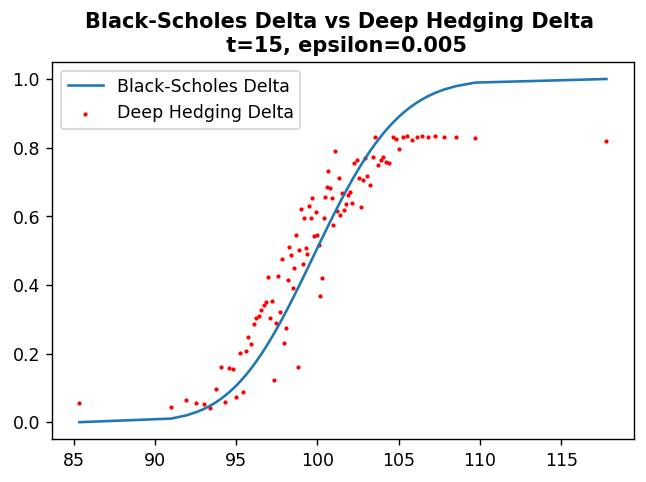

In [8]:
#@title <font color='Blue'>**Results: Black-Scholes Delta vs Deep Hedging Delta.**</font>
days_from_today = 15

# x-axis: [Min_S, 10th percentile, ..., 90th percentile,  Max_S]
S_range = np.sort(S_test[0][:,days_from_today])
idx2select = np.append(np.arange(0, len(S_range), \
				int(len(S_range)/100)), len(S_range)-1)

# Compute NN delta.
submodel = Model(model.input, model.get_layer("dense_" + str(d+1) \
						  + "_" + str(days_from_today)).output)
nn_delta = submodel.predict(xtest, batch_size=1000,verbose=0)

tmp_stack = np.stack((S_test[0][:,days_from_today],reshape_1D(nn_delta)),axis=1)
tmp_stack = tmp_stack[tmp_stack[:,0].argsort()]
tmp_stack = tmp_stack[idx2select]

S_range = tmp_stack[:,0]
nn_delta = tmp_stack[:,1]

# Compute Black-Scholes delta for S_range.
model_delta = np.zeros(S_range.shape)
for i in range(len(S_range)):
  model_delta[i] = report.get_model_delta(instrument, s0= S_range[i], \
          calculation_date=calculation_date + days_from_today)
  
# Create a plot of Black-Scholes delta against deep hedging delta.
fig_delta = plt.figure(dpi= 125, facecolor='w')
plt.plot(S_range, model_delta, label="Black-Scholes Delta")
plt.scatter(S_range,nn_delta, c="red", s=2, label="Deep Hedging Delta")
plt.title("Black-Scholes Delta vs Deep Hedging Delta \n " + \
          "t=" + str(days_from_today) + ", " + \
          "epsilon=" + str(epsilon), fontweight="bold")
plt.legend()
plt.show()